In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import time
from torchinfo import summary

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device is using: {device}")

Current device is using: cuda


In [2]:
# ---------------------
# Define Helper Classes and Functions
# ---------------------
class MultiStepTimeSeriesDataset(Dataset):
    """
    Dataset for multi-step forecasting. Inputs are sequences of length `seq_len`,
    and targets are `forecast_horizon` steps ahead.
    """
    def __init__(self, X, y, seq_len, forecast_horizon):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        return len(self.X) - self.seq_len - self.forecast_horizon + 1

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx:idx + self.seq_len], dtype=torch.float32),
            torch.tensor(self.y[idx + self.seq_len:idx + self.seq_len + self.forecast_horizon], dtype=torch.float32),
        )

class LSTMForecastModel(nn.Module):
    """
    LSTM model for multi-step forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=3, dropout=0.3):
        super(LSTMForecastModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, forecast_horizon)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # Output based on the last hidden state

class LSTMMonteCarlo(nn.Module):
    """
    LSTM model with Monte Carlo dropout for uncertainty estimation.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=2, dropout=0.2, recurrent_dropout=0.2):
        """
        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden units in each LSTM layer.
            forecast_horizon: Number of steps to forecast.
            num_layers: Number of stacked LSTM layers.
            dropout: Dropout rate applied to the fully connected layer.
            recurrent_dropout: Dropout rate applied between LSTM layers.
        """
        super(LSTMMonteCarlo, self).__init__()

        # LSTM layer(s)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=recurrent_dropout  # Recurrent dropout
        )
        
        # Layer normalization (optional but improves convergence)
        self.layer_norm = nn.LayerNorm(hidden_size)

        # Dropout for fully connected layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer for final output
        self.fc = nn.Linear(hidden_size, forecast_horizon)

    def forward(self, x):
        """
        Forward pass through LSTM with Monte Carlo dropout.
        """
        # LSTM output: (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)

        # Take the last hidden state
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Normalize and apply dropout
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)

        # Final output through fully connected layer
        return self.fc(lstm_out)

def lstm_monte_carlo_dropout_inference(model, inputs, n_simulations=100, verbose=False):
    """
    Perform Monte Carlo dropout during inference to estimate uncertainty.

    Args:
        model: Trained LSTMMonteCarlo model.
        inputs: Input tensor for prediction (shape: [batch_size, seq_len, input_size]).
        n_simulations: Number of Monte Carlo simulations.
        verbose: Whether to print intermediate predictions for debugging.

    Returns:
        mean_predictions: Mean of predictions across simulations.
        uncertainty: Standard deviation of predictions across simulations.
    """
    model.train()  # Keep dropout active during inference
    predictions = []

    with torch.no_grad():
        for i in range(n_simulations):
            pred = model(inputs)  # Shape: [batch_size, forecast_horizon]
            predictions.append(pred.cpu().numpy())
            if verbose:
                print(f"Simulation {i + 1}: {pred.cpu().numpy()}")

    # Convert predictions to numpy array
    predictions = np.array(predictions)  # Shape: [n_simulations, batch_size, forecast_horizon]

    # Compute mean and standard deviation across simulations
    mean_predictions = np.mean(predictions, axis=0)  # Shape: [batch_size, forecast_horizon]
    uncertainty = np.std(predictions, axis=0)        # Shape: [batch_size, forecast_horizon]

    return mean_predictions, uncertainty


class LSTMCNN(nn.Module):
    """
    LSTM-CNN hybrid model for multi-step time series forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=2, cnn_filters=128, kernel_size=3, dropout=0.2):
        """
        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden units in the LSTM layer.
            forecast_horizon: Number of steps ahead to forecast.
            num_layers: Number of stacked LSTM layers.
            cnn_filters: Number of filters in the CNN layer.
            kernel_size: Size of the convolution kernel.
            dropout: Dropout probability for regularization.
        """
        super(LSTMCNN, self).__init__()
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # CNN Layer
        self.conv = nn.Conv1d(
            in_channels=hidden_size, 
            out_channels=cnn_filters, 
            kernel_size=kernel_size, 
            padding=kernel_size // 2  # To maintain the same spatial size
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(cnn_filters, forecast_horizon)
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass for LSTM-CNN model.
        """
        # LSTM output: (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        # Permute for CNN: (batch_size, hidden_size, seq_len)
        lstm_out = lstm_out.permute(0, 2, 1)
        # Apply CNN: (batch_size, cnn_filters, seq_len)
        cnn_out = self.conv(lstm_out)
        # Global Average Pooling: (batch_size, cnn_filters)
        cnn_out = cnn_out.mean(dim=-1)
        # Dropout for regularization
        cnn_out = self.dropout(cnn_out)
        # Fully Connected Layer
        output = self.fc(cnn_out)
        
        return output

class RNNForecastModel(nn.Module):
    """
    Vanilla RNN model for multi-step forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=3, dropout=0.3):
        super(RNNForecastModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu', dropout=dropout)
        self.fc = nn.Linear(hidden_size, forecast_horizon)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

        
class LSTMRNNForecastModel(nn.Module):
    """
    LSTM-RNN hybrid model for multi-step forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=3, dropout=0.3):
        super(LSTMRNNForecastModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu', dropout=dropout)
        self.fc = nn.Linear(hidden_size, forecast_horizon)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        rnn_out, _ = self.rnn(lstm_out)
        return self.fc(rnn_out[:, -1, :])  # Output based on the last hidden state

def scale_data(df, features, target, method="normalize"):
    """
    Normalize or standardize data using MinMaxScaler or StandardScaler.
    """
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    X = feature_scaler.fit_transform(df[features])
    y = target_scaler.fit_transform(df[target].values.reshape(-1, 1))

    return X, y.ravel(), feature_scaler, target_scaler


In [3]:
# Load the dataset
data = pd.read_csv('data/final_df.csv')
data.set_index("Date", inplace=True)

# Define features and target
features = [
    'Open', 'High', 'Low', 'GDP (constant 2015 MYR)', 'GDP Growth YOY (%)', 
    'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'RSI_50', 'BB_upper', 
    'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D', 'GDP (constant 2015 MYR)_Lag_90D', 
    'GDP (constant 2015 MYR)_Lag_180D', 'GDP (constant 2015 MYR)_Lag_365D', 
    'OPR (%)_Lag_30D', 'OPR (%)_Lag_90D', 'Lagged_Close_30D', 'Lagged_Close_90D', 
    'Lagged_Close_180D', 'Lagged_Close_365D'
]
target = "Close"

# Normalize data
X, y, feature_scaler, target_scaler = scale_data(data, features, target)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# ---------------------
# Step 2: Model Training
# ---------------------
seq_len = 30  # Sequence length
forecast_horizon = 31  # Forecast for August 2024 (31 days)

# Initialize model
model = RNNForecastModel(
    input_size=X_train.shape[1], 
    hidden_size=300, 
    forecast_horizon=forecast_horizon, 
    num_layers=3, 
    # nonlinearity='tanh',
    dropout=0.3
).to(device)

# Print the summary
# summary(model, input_size=(30, X_train.shape[1]))  # (sequence length, input features)
summary(model, input_size=(32, forecast_horizon, X_train.shape[1]))


Layer (type:depth-idx)                   Output Shape              Param #
RNNForecastModel                         [32, 31]                  --
├─RNN: 1-1                               [32, 31, 300]             458,700
├─Linear: 1-2                            [32, 31]                  9,331
Total params: 468,031
Trainable params: 468,031
Non-trainable params: 0
Total mult-adds (M): 455.33
Input size (MB): 0.09
Forward/backward pass size (MB): 2.39
Params size (MB): 1.87
Estimated Total Size (MB): 4.35

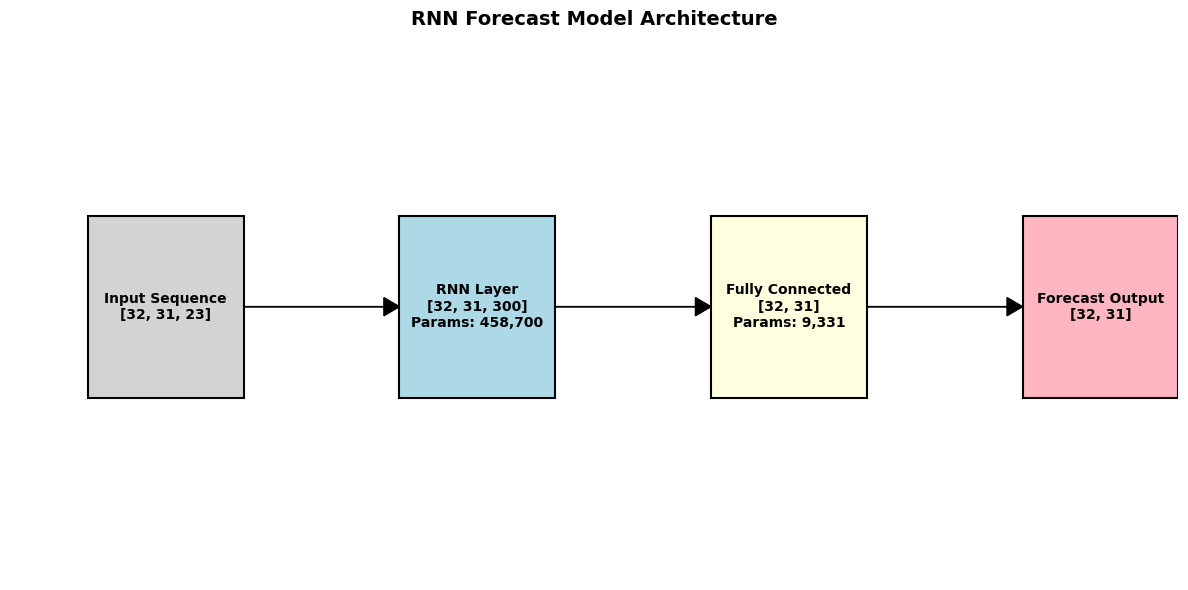

In [13]:
def draw_rnn_forecast_model():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("RNN Forecast Model Architecture", fontsize=14, fontweight="bold")

    # Draw the architecture as a flowchart with distinct colors for each layer
    def draw_rectangle(label, xy, width=2, height=1, color="lightblue"):
        rect = patches.Rectangle(xy, width, height, linewidth=1.5, edgecolor="black", facecolor=color)
        ax.add_patch(rect)
        ax.text(xy[0] + width / 2, xy[1] + height / 2, label, ha="center", va="center", fontsize=10, fontweight="bold")

    def draw_arrow(start, end, arrow_size=0.05):
        ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                 head_width=arrow_size, head_length=0.2, length_includes_head=True, color="black")

    # Input
    draw_rectangle("Input Sequence\n[32, 31, 23]", (1, 5), color="lightgray")

    # RNN Layer
    draw_arrow((3, 5.5), (5, 5.5), arrow_size=0.1)
    draw_rectangle("RNN Layer\n[32, 31, 300]\nParams: 458,700", (5, 5), color="lightblue")

    # Fully Connected Layer
    draw_arrow((7, 5.5), (9, 5.5), arrow_size=0.1)
    draw_rectangle("Fully Connected\n[32, 31]\nParams: 9,331", (9, 5), color="lightyellow")

    # Final Output
    draw_arrow((11, 5.5), (13, 5.5), arrow_size=0.1)
    draw_rectangle("Forecast Output\n[32, 31]", (13, 5), color="lightpink")

    # Adjust plot limits and hide axes
    ax.set_xlim(0, 15)
    ax.set_ylim(4, 7)
    ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_rnn_forecast_model()


In [4]:
# Load the dataset
data = pd.read_csv('data/final_df.csv')
data.set_index("Date", inplace=True)

# Define features and target
features = [
    'Open', 'High', 'Low', 'GDP (constant 2015 MYR)', 'GDP Growth YOY (%)', 
    'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'RSI_50', 'BB_upper', 
    'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D', 'GDP (constant 2015 MYR)_Lag_90D', 
    'GDP (constant 2015 MYR)_Lag_180D', 'GDP (constant 2015 MYR)_Lag_365D', 
    'OPR (%)_Lag_30D', 'OPR (%)_Lag_90D', 'Lagged_Close_30D', 'Lagged_Close_90D', 
    'Lagged_Close_180D', 'Lagged_Close_365D'
]
target = "Close"

# Normalize data
X, y, feature_scaler, target_scaler = scale_data(data, features, target)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# ---------------------
# Step 2: Model Training
# ---------------------
seq_len = 30  # Sequence length
forecast_horizon = 31  # Forecast for August 2024 (31 days)

# Initialize model
# Define dummy batch_first input for torchsummary
class LSTMForecastModelWrapper(nn.Module):
    def __init__(self, model):
        super(LSTMForecastModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Simulate batch_first=True behavior
        return self.model(x)

# Initialize model
model = LSTMForecastModel(
    input_size=X_train.shape[1],  # Number of input features
    hidden_size=300,             # LSTM hidden size
    forecast_horizon=forecast_horizon,  # Forecast horizon
    num_layers=3,                # Number of LSTM layers
    dropout=0.3                  # Dropout rate
).to(device)

summary(model, input_size=(32, forecast_horizon, X_train.shape[1]))

# print(model)


Layer (type:depth-idx)                   Output Shape              Param #
LSTMForecastModel                        [32, 31]                  --
├─LSTM: 1-1                              [32, 31, 300]             1,834,800
├─Linear: 1-2                            [32, 31]                  9,331
Total params: 1,844,131
Trainable params: 1,844,131
Non-trainable params: 0
Total mult-adds (G): 1.82
Input size (MB): 0.09
Forward/backward pass size (MB): 2.39
Params size (MB): 7.38
Estimated Total Size (MB): 9.86

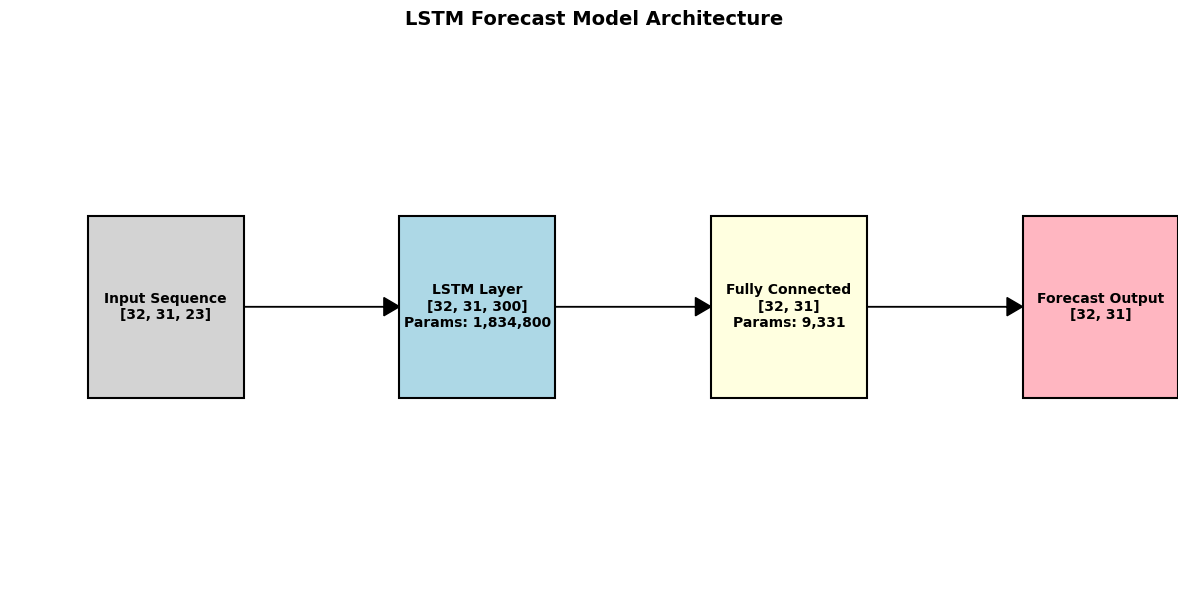

In [12]:
def draw_lstm_forecast_model():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("LSTM Forecast Model Architecture", fontsize=14, fontweight="bold")

    # Draw the architecture as a flowchart with distinct colors for each layer
    def draw_rectangle(label, xy, width=2, height=1, color="lightblue"):
        rect = patches.Rectangle(xy, width, height, linewidth=1.5, edgecolor="black", facecolor=color)
        ax.add_patch(rect)
        ax.text(xy[0] + width / 2, xy[1] + height / 2, label, ha="center", va="center", fontsize=10, fontweight="bold")

    def draw_arrow(start, end, arrow_size=0.05):
        ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                 head_width=arrow_size, head_length=0.2, length_includes_head=True, color="black")

    # Input
    draw_rectangle("Input Sequence\n[32, 31, 23]", (1, 5), color="lightgray")

    # LSTM Layer
    draw_arrow((3, 5.5), (5, 5.5), arrow_size=0.1)
    draw_rectangle("LSTM Layer\n[32, 31, 300]\nParams: 1,834,800", (5, 5), color="lightblue")

    # Fully Connected Layer
    draw_arrow((7, 5.5), (9, 5.5), arrow_size=0.1)
    draw_rectangle("Fully Connected\n[32, 31]\nParams: 9,331", (9, 5), color="lightyellow")

    # Final Output
    draw_arrow((11, 5.5), (13, 5.5), arrow_size=0.1)
    draw_rectangle("Forecast Output\n[32, 31]", (13, 5), color="lightpink")

    # Adjust plot limits and hide axes
    ax.set_xlim(0, 15)
    ax.set_ylim(4, 7)
    ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_lstm_forecast_model()


In [5]:
# Load the dataset
data = pd.read_csv('data/final_df.csv')
data.set_index("Date", inplace=True)

# Define features and target
features = [
    'Open', 'High', 'Low', 'GDP (constant 2015 MYR)', 'GDP Growth YOY (%)', 
    'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'RSI_50', 'BB_upper', 
    'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D', 'GDP (constant 2015 MYR)_Lag_90D', 
    'GDP (constant 2015 MYR)_Lag_180D', 'GDP (constant 2015 MYR)_Lag_365D', 
    'OPR (%)_Lag_30D', 'OPR (%)_Lag_90D', 'Lagged_Close_30D', 'Lagged_Close_90D', 
    'Lagged_Close_180D', 'Lagged_Close_365D'
]
target = "Close"

# Normalize data
X, y, feature_scaler, target_scaler = scale_data(data, features, target)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# ---------------------
# Step 2: Model Training
# ---------------------
seq_len = 30  # Sequence length
forecast_horizon = 31  # Forecast for August 2024 (31 days)

# Initialize model
# Define dummy batch_first input for torchsummary
class LSTMForecastModelWrapper(nn.Module):
    def __init__(self, model):
        super(LSTMForecastModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Simulate batch_first=True behavior
        return self.model(x)

# Initialize model
model = LSTMRNNForecastModel(
    input_size=X_train.shape[1], 
    hidden_size=300, 
    forecast_horizon=forecast_horizon, 
    num_layers=3, 
    dropout=0.3
).to(device)

summary(model, input_size=(32, forecast_horizon, X_train.shape[1]))

# print(model)


Layer (type:depth-idx)                   Output Shape              Param #
LSTMRNNForecastModel                     [32, 31]                  --
├─LSTM: 1-1                              [32, 31, 300]             1,834,800
├─RNN: 1-2                               [32, 31, 300]             541,800
├─Linear: 1-3                            [32, 31]                  9,331
Total params: 2,385,931
Trainable params: 2,385,931
Non-trainable params: 0
Total mult-adds (G): 2.36
Input size (MB): 0.09
Forward/backward pass size (MB): 4.77
Params size (MB): 9.54
Estimated Total Size (MB): 14.40

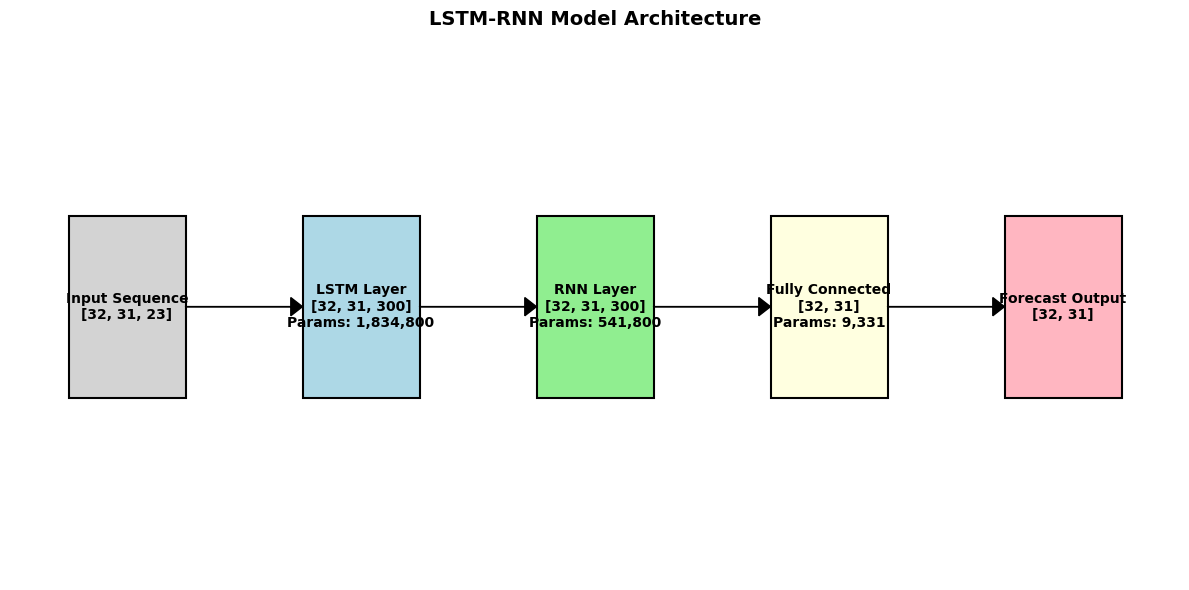

In [11]:
def draw_lstm_rnn_model():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("LSTM-RNN Model Architecture", fontsize=14, fontweight="bold")

    # Draw the architecture as a flowchart with distinct colors for each layer
    def draw_rectangle(label, xy, width=2, height=1, color="lightblue"):
        rect = patches.Rectangle(xy, width, height, linewidth=1.5, edgecolor="black", facecolor=color)
        ax.add_patch(rect)
        ax.text(xy[0] + width / 2, xy[1] + height / 2, label, ha="center", va="center", fontsize=10, fontweight="bold")

    def draw_arrow(start, end, arrow_size=0.05):
        ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                 head_width=arrow_size, head_length=0.2, length_includes_head=True, color="black")

    # Input
    draw_rectangle("Input Sequence\n[32, 31, 23]", (1, 5), color="lightgray")

    # LSTM Layer
    draw_arrow((3, 5.5), (5, 5.5), arrow_size=0.1)
    draw_rectangle("LSTM Layer\n[32, 31, 300]\nParams: 1,834,800", (5, 5), color="lightblue")

    # RNN Layer
    draw_arrow((7, 5.5), (9, 5.5), arrow_size=0.1)
    draw_rectangle("RNN Layer\n[32, 31, 300]\nParams: 541,800", (9, 5), color="lightgreen")

    # Fully Connected Layer
    draw_arrow((11, 5.5), (13, 5.5), arrow_size=0.1)
    draw_rectangle("Fully Connected\n[32, 31]\nParams: 9,331", (13, 5), color="lightyellow")

    # Final Output
    draw_arrow((15, 5.5), (17, 5.5), arrow_size=0.1)
    draw_rectangle("Forecast Output\n[32, 31]", (17, 5), color="lightpink")

    # Adjust plot limits and hide axes
    ax.set_xlim(0, 20)
    ax.set_ylim(4, 7)
    ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_lstm_rnn_model()


In [6]:
# Load the dataset
data = pd.read_csv('data/final_df.csv')
data.set_index("Date", inplace=True)

# Define features and target
features = [
    'Open', 'High', 'Low', 'GDP (constant 2015 MYR)', 'GDP Growth YOY (%)', 
    'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'RSI_50', 'BB_upper', 
    'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D', 'GDP (constant 2015 MYR)_Lag_90D', 
    'GDP (constant 2015 MYR)_Lag_180D', 'GDP (constant 2015 MYR)_Lag_365D', 
    'OPR (%)_Lag_30D', 'OPR (%)_Lag_90D', 'Lagged_Close_30D', 'Lagged_Close_90D', 
    'Lagged_Close_180D', 'Lagged_Close_365D'
]
target = "Close"

# Normalize data
X, y, feature_scaler, target_scaler = scale_data(data, features, target)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# ---------------------
# Step 2: Model Training
# ---------------------
seq_len = 30  # Sequence length
forecast_horizon = 31  # Forecast for August 2024 (31 days)

# Initialize model
# Define dummy batch_first input for torchsummary
class LSTMForecastModelWrapper(nn.Module):
    def __init__(self, model):
        super(LSTMForecastModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Simulate batch_first=True behavior
        return self.model(x)

# Initialize model
model = LSTMMonteCarlo(
    input_size=X_train.shape[1], 
    hidden_size=300, 
    forecast_horizon=forecast_horizon, 
    num_layers=3, 
    dropout=0.3,
    recurrent_dropout=0.3
).to(device)

summary(model, input_size=(32, forecast_horizon, X_train.shape[1]))

# print(model)


Layer (type:depth-idx)                   Output Shape              Param #
LSTMMonteCarlo                           [32, 31]                  --
├─LSTM: 1-1                              [32, 31, 300]             1,834,800
├─LayerNorm: 1-2                         [32, 300]                 600
├─Dropout: 1-3                           [32, 300]                 --
├─Linear: 1-4                            [32, 31]                  9,331
Total params: 1,844,731
Trainable params: 1,844,731
Non-trainable params: 0
Total mult-adds (G): 1.82
Input size (MB): 0.09
Forward/backward pass size (MB): 2.47
Params size (MB): 7.38
Estimated Total Size (MB): 9.94

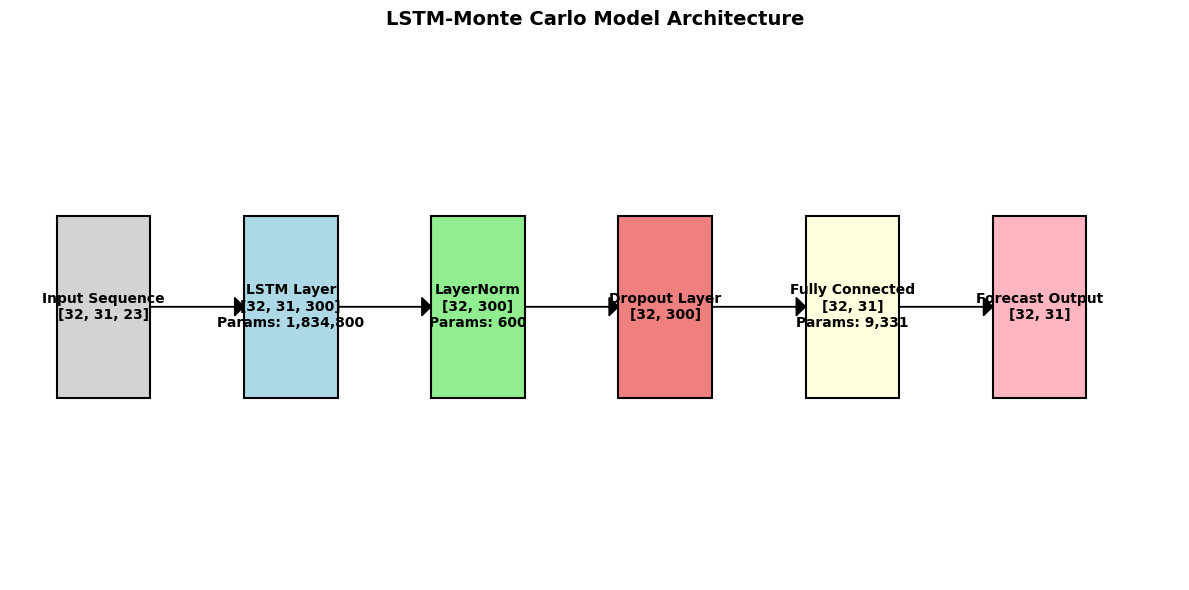

In [10]:
def draw_lstm_mc_model():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("LSTM-Monte Carlo Model Architecture", fontsize=14, fontweight="bold")

    # Draw the architecture as a flowchart with distinct colors for each layer
    def draw_rectangle(label, xy, width=2, height=1, color="lightblue"):
        rect = patches.Rectangle(xy, width, height, linewidth=1.5, edgecolor="black", facecolor=color)
        ax.add_patch(rect)
        ax.text(xy[0] + width / 2, xy[1] + height / 2, label, ha="center", va="center", fontsize=10, fontweight="bold")

    def draw_arrow(start, end, arrow_size=0.05):
        ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                 head_width=arrow_size, head_length=0.2, length_includes_head=True, color="black")

    # Input
    draw_rectangle("Input Sequence\n[32, 31, 23]", (1, 5), color="lightgray")

    # LSTM Layer
    draw_arrow((3, 5.5), (5, 5.5), arrow_size=0.1)
    draw_rectangle("LSTM Layer\n[32, 31, 300]\nParams: 1,834,800", (5, 5), color="lightblue")

    # LayerNorm
    draw_arrow((7, 5.5), (9, 5.5), arrow_size=0.1)
    draw_rectangle("LayerNorm\n[32, 300]\nParams: 600", (9, 5), color="lightgreen")

    # Dropout Layer
    draw_arrow((11, 5.5), (13, 5.5), arrow_size=0.1)
    draw_rectangle("Dropout Layer\n[32, 300]", (13, 5), color="lightcoral")

    # Fully Connected Layer
    draw_arrow((15, 5.5), (17, 5.5), arrow_size=0.1)
    draw_rectangle("Fully Connected\n[32, 31]\nParams: 9,331", (17, 5), color="lightyellow")

    # Final Output
    draw_arrow((19, 5.5), (21, 5.5), arrow_size=0.1)
    draw_rectangle("Forecast Output\n[32, 31]", (21, 5), color="lightpink")

    # Adjust plot limits and hide axes
    ax.set_xlim(0, 25)
    ax.set_ylim(4, 7)
    ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_lstm_mc_model()


In [7]:
# Load the dataset
data = pd.read_csv('data/final_df.csv')
data.set_index("Date", inplace=True)

# Define features and target
features = [
    'Open', 'High', 'Low', 'GDP (constant 2015 MYR)', 'GDP Growth YOY (%)', 
    'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'RSI_50', 'BB_upper', 
    'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D', 'GDP (constant 2015 MYR)_Lag_90D', 
    'GDP (constant 2015 MYR)_Lag_180D', 'GDP (constant 2015 MYR)_Lag_365D', 
    'OPR (%)_Lag_30D', 'OPR (%)_Lag_90D', 'Lagged_Close_30D', 'Lagged_Close_90D', 
    'Lagged_Close_180D', 'Lagged_Close_365D'
]
target = "Close"

# Normalize data
X, y, feature_scaler, target_scaler = scale_data(data, features, target)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# ---------------------
# Step 2: Model Training
# ---------------------
seq_len = 30  # Sequence length
forecast_horizon = 31  # Forecast for August 2024 (31 days)

# Initialize model
# Define dummy batch_first input for torchsummary
class LSTMForecastModelWrapper(nn.Module):
    def __init__(self, model):
        super(LSTMForecastModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Simulate batch_first=True behavior
        return self.model(x)

# Initialize model
model = LSTMCNN(
    input_size=X_train.shape[1],  # Number of input features
    hidden_size=300,             # Hidden size in LSTM
    forecast_horizon=forecast_horizon,         # Forecast horizon (30 days)
    num_layers=3,                # Number of LSTM layers
    cnn_filters=64,              # Number of CNN filters
    kernel_size=3,               # Kernel size for CNN
    dropout=0.3                  # Dropout probability
).to(device)

summary(model, input_size=(32, forecast_horizon, X_train.shape[1]))

# print(model)


Layer (type:depth-idx)                   Output Shape              Param #
LSTMCNN                                  [32, 31]                  --
├─LSTM: 1-1                              [32, 31, 300]             1,834,800
├─Conv1d: 1-2                            [32, 64, 31]              57,664
├─Dropout: 1-3                           [32, 64]                  --
├─Linear: 1-4                            [32, 31]                  2,015
Total params: 1,894,479
Trainable params: 1,894,479
Non-trainable params: 0
Total mult-adds (G): 1.88
Input size (MB): 0.09
Forward/backward pass size (MB): 2.90
Params size (MB): 7.58
Estimated Total Size (MB): 10.57

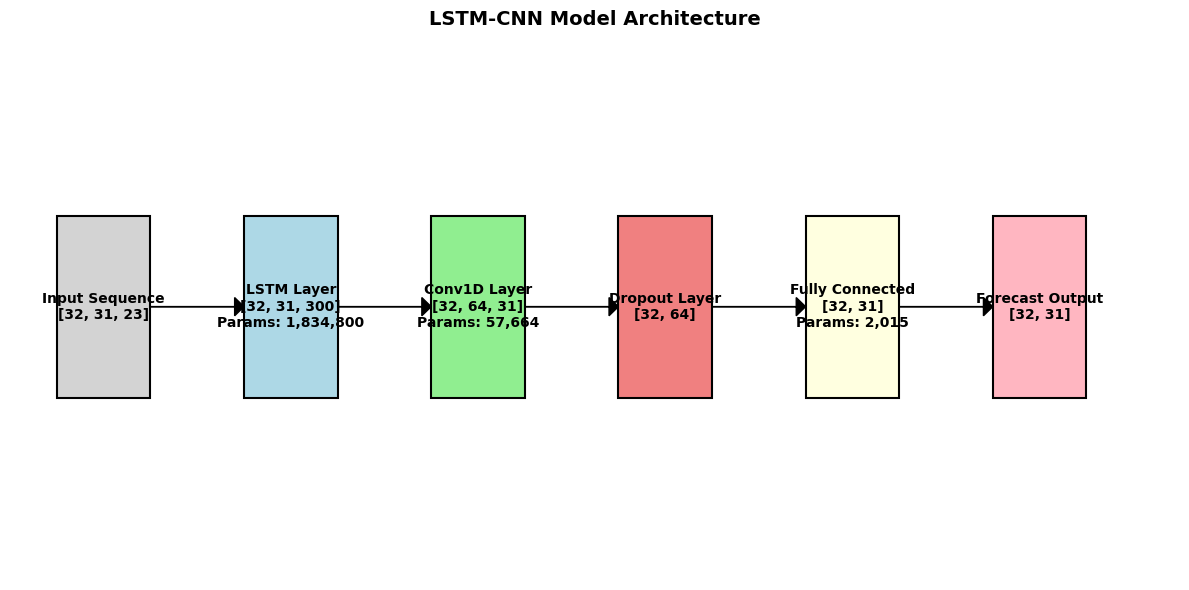

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_lstm_cnn_model_v2():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("LSTM-CNN Model Architecture", fontsize=14, fontweight="bold")
    
    # Draw the architecture as a flowchart with distinct colors for each layer
    def draw_rectangle(label, xy, width=2, height=1, color="lightblue"):
        rect = patches.Rectangle(xy, width, height, linewidth=1.5, edgecolor="black", facecolor=color)
        ax.add_patch(rect)
        ax.text(xy[0] + width / 2, xy[1] + height / 2, label, ha="center", va="center", fontsize=10, fontweight="bold")

    def draw_arrow(start, end, arrow_size=0.05):
        ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                 head_width=arrow_size, head_length=0.2, length_includes_head=True, color="black")

    # Input
    draw_rectangle("Input Sequence\n[32, 31, 23]", (1, 5), color="lightgray")

    # LSTM Layer
    draw_arrow((3, 5.5), (5, 5.5), arrow_size=0.1)
    draw_rectangle("LSTM Layer\n[32, 31, 300]\nParams: 1,834,800", (5, 5), color="lightblue")

    # Conv1D Layer
    draw_arrow((7, 5.5), (9, 5.5), arrow_size=0.1)
    draw_rectangle("Conv1D Layer\n[32, 64, 31]\nParams: 57,664", (9, 5), color="lightgreen")

    # Dropout Layer
    draw_arrow((11, 5.5), (13, 5.5), arrow_size=0.1)
    draw_rectangle("Dropout Layer\n[32, 64]", (13, 5), color="lightcoral")

    # Fully Connected Layer
    draw_arrow((15, 5.5), (17, 5.5), arrow_size=0.1)
    draw_rectangle("Fully Connected\n[32, 31]\nParams: 2,015", (17, 5), color="lightyellow")

    # Final Output
    draw_arrow((19, 5.5), (21, 5.5), arrow_size=0.1)
    draw_rectangle("Forecast Output\n[32, 31]", (21, 5), color="lightpink")

    # Adjust plot limits and hide axes
    ax.set_xlim(0, 25)
    ax.set_ylim(4, 7)
    ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_lstm_cnn_model_v2()
